In [1]:
import os
os.environ["KERAS BACKEND"] = "tensorflow"
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import skforecast
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.plot import set_dark_theme

from keras.models import save_model, load_model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("once")

print(f"skforecast version: {skforecast.__version__}")
print(f"keras version: {keras.__version__}")
# print(f"Tensorflow version: {keras.__version__}")
# print(f"Pytorch version: {keras.__version__}")

if keras.__version__ > "3.0":
    print(f"Using backend: {keras.backend.backend()}")
    if keras.backend.backend() == "tensorflow":
        print(f"Tensorflow version: {keras.__version__}")
        import tensorflow as tf
    elif keras.backend.backend() == "torch":
        print(f"Pytorch version: {keras.__version__}")
        import torch
    else:
        print(f"Backend not recognized")

2024-09-26 10:15:28.177315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 10:15:28.206599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 10:15:28.215096: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 10:15:28.245789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 10:15:29.648308: W tensorflow/comp

skforecast version: 0.13.0
keras version: 3.5.0
Using backend: tensorflow
Tensorflow version: 3.5.0


2024-09-26 10:15:33.505824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47378 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:2f:00.0, compute capability: 7.5
/home/alumno/anaconda3/envs/ia4flood_keras/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [3]:
# Create sequences

def create_sequences(data, lookback):
    xs = []
    ys = []
    for i in range(len(data)-lookback):
        x = data[i:(i+lookback)]
        y = data[i+lookback]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def find_nan_sequences(df, max_consecutive_nans=120, view=False):
    nan_index = df[df.isnull().any(axis=1)].index
    # print(nan_index)
    nan_sequences = []
    
    if len(nan_index) == 0:
        return nan_sequences

    start_date = nan_index[0]
    prev_date = nan_index[0]
    
    for i in range(1, len(nan_index)):
        current_date = nan_index[i]
        
        if current_date - prev_date != pd.Timedelta('1 hour 00:00:00'):
            # No es consecutivo, guardar la secuencia anterior
            end_date = prev_date
            num_nans = (end_date - start_date).total_seconds() / 3600 + 1
            
            if num_nans == 1:
                nan_sequences.append({
                    'type': 'single',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans <= max_consecutive_nans:
                nan_sequences.append({
                    'type': 'consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            elif num_nans > max_consecutive_nans:
                nan_sequences.append({
                    'type': 'long_consecutive',
                    'start_date': start_date,
                    'end_date': end_date,
                    'num_nans': num_nans
                })
            else:
                if view:
                    print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
            
            # Iniciar una nueva secuencia
            start_date = current_date
        
        prev_date = current_date
    
    # Manejar la última secuencia
    end_date = prev_date
    num_nans = (end_date - start_date).total_seconds() / 3600 + 1
    
    if num_nans == 1:
        nan_sequences.append({
            'type': 'single',
            'date': start_date
        })
    elif num_nans <= max_consecutive_nans:
        nan_sequences.append({
            'type': 'consecutive',
            'start_date': start_date,
            'end_date': end_date,
            'num_nans': num_nans
        })
    else:
        if view:
            print(f'Secuencia de NaN mayor a {max_consecutive_nans} horas: {start_date} a {end_date}, {num_nans} valores')
    
    return nan_sequences

In [8]:
# Guardar la variable imputation_lluvia_aitsu en otra variable para las modificaciones
variable = 'NIVEL_RIO_Aitzu-Urola','LLUVIA_Aitzu-Urola','CAUDAL_RIO_Aitzu-Urola'
data_river_2 = pd.read_csv('db_21.csv')
data_river_2 = data_river_2.set_index('Fecha')
# Asignar un formato de fecha a la columna fecha
data_river_2.index = pd.to_datetime(data_river_2.index, format='%Y-%m-%d %H:%M:%S')
# Se trabajara sobre la variable de nivel del rio Aitzu-Urola 
imputation_lluvia_aitsu = data_river_2[['NIVEL_RIO_Aitzu-Urola','LLUVIA_Aitzu-Urola','CAUDAL_RIO_Aitzu-Urola']].copy()
date_init = '1999-03-16 17:00'
date_end = '2023-09-30 23:00'
imputation_lluvia_aitsu = imputation_lluvia_aitsu[date_init:date_end] 

In [9]:
# Uso de la función
nan_sequences = find_nan_sequences(imputation_lluvia_aitsu, max_consecutive_nans=120, view=True)

# Imprimir resultados
for x in nan_sequences:
    print(x)

{'type': 'long_consecutive', 'start_date': Timestamp('1999-03-16 17:00:00'), 'end_date': Timestamp('2000-04-05 12:00:00'), 'num_nans': 9260.0}
{'type': 'single', 'start_date': Timestamp('2000-05-25 08:00:00'), 'end_date': Timestamp('2000-05-25 08:00:00'), 'num_nans': 1.0}
{'type': 'single', 'start_date': Timestamp('2000-12-08 03:00:00'), 'end_date': Timestamp('2000-12-08 03:00:00'), 'num_nans': 1.0}
{'type': 'consecutive', 'start_date': Timestamp('2000-12-12 00:00:00'), 'end_date': Timestamp('2000-12-12 23:00:00'), 'num_nans': 24.0}
{'type': 'single', 'start_date': Timestamp('2000-12-15 16:00:00'), 'end_date': Timestamp('2000-12-15 16:00:00'), 'num_nans': 1.0}
{'type': 'single', 'start_date': Timestamp('2000-12-23 09:00:00'), 'end_date': Timestamp('2000-12-23 09:00:00'), 'num_nans': 1.0}
{'type': 'single', 'start_date': Timestamp('2000-12-23 17:00:00'), 'end_date': Timestamp('2000-12-23 17:00:00'), 'num_nans': 1.0}
{'type': 'single', 'start_date': Timestamp('2000-12-23 23:00:00'), 'end

In [10]:
x = 1
# init_train = nan_sequences[0]['end_date'] + pd.Timedelta('1 hour 00:00:00')
end_train = nan_sequences[x]['start_date'] - pd.Timedelta('1 hour 00:00:00')
data_river = imputation_lluvia_aitsu[:end_train]
print('Fecha de inicio para el entrenamiento ----> ', data_river.index[0])
print('Fecha de fin del entrenamiento ------> ', data_river.index[-1])

data_river.index.freq = 'h'
# print(data_river_normalized)
print(f"Index: , {data_river.index.dtype}")
print(f"Frecuency: , {data_river.index.freq}")

train_size = int(len(data_river) * 0.70)
val_size = int((len(data_river) * 0.15))
test_size = int(len(data_river) * 0.15)

train, val = data_river[:train_size], data_river[train_size:val_size + train_size]
test = pd.concat([data_river[val_size + train_size:]])
# The last value in test is equal a 0
# test.iloc[-1,-1] = 0
 

print(f"Fecha de entrenamiento : {train.index.min()} ---"
      f"{train.index.max()} (n = {len(train)})")
print(f"Fecha de validacion : {val.index.min()} ---"
      f"{val.index.max()} (n = {len(val)})")
print(f"Fecha de test : {test.index.min()} ---"
      f"{test.index.max()} (n = {len(test)})")

Fecha de inicio para el entrenamiento ---->  1999-03-16 17:00:00
Fecha de fin del entrenamiento ------>  2000-05-25 07:00:00
Index: , datetime64[ns]
Frecuency: , <Hour>
Fecha de entrenamiento : 1999-03-16 17:00:00 ---2000-01-15 14:00:00 (n = 7318)
Fecha de validacion : 2000-01-15 15:00:00 ---2000-03-20 22:00:00 (n = 1568)
Fecha de test : 2000-03-20 23:00:00 ---2000-05-25 07:00:00 (n = 1569)


In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train.values.flatten(),
                         mode='lines', name='Train', line=dict(color='blue', width=2)))

fig.add_trace(go.Scatter(x=val.index, y=val.values.flatten(),
                         mode='lines', name='Val', line=dict(color='green', width=2)))

fig.add_trace(go.Scatter(x=test.index, y=test.values.flatten(),
                         mode='lines', name='Test', line=dict(color='red', width=2)))

In [20]:
series = ['NIVEL_RIO_Aitzu-Urola','LLUVIA_Aitzu-Urola','CAUDAL_RIO_Aitzu-Urola']
levels = ["NIVEL_RIO_Aitzu-Urola"]
lags = 32
steps = 5

data = data_river_2[series].copy()
data_train = train[series].copy()
data_val = val[series].copy()
data_test = test[series].copy()

model = create_and_compile_model(
    series = data_train,
    levels = levels,
    lags = lags,
    steps = steps,
    recurrent_layer = 'LSTM',
    recurrent_units = [100, 50],
    dense_units = [64, 32],
    optimizer = Adam(learning_rate=0.0001),
    loss = MeanSquaredError(),
)
model.summary()

keras version: 3.5.0
Using backend: tensorflow
tensorflow version: 2.17.0


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,309 (301.99 KB)

 Trainable params: 77,309 (301.99 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
forecaster = ForecasterRnn(
    regressor = model,
    levels = levels,
    steps = steps,
    lags = lags,
    transformer_series = MinMaxScaler(),
    fit_kwargs = {
        "epochs" : 200,
        "batch_size" : 128,
        "series_val" : data_val,
    },  
)

forecaster

ForecasterRnn 
Regressor: <Functional name=functional_2, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['NIVEL_RIO_Aitzu-Urola'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_2', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None, 'name': 'input_layer_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False

In [26]:
forecaster.fit(data_train)

ValueError: Minimum length of `series` for training this forecaster is 37. Got 0. Reduce the number of predicted steps, 5, or the maximum lag, 32, if no more data is available.

In [11]:
# print(forecaster.transformer_series.min_)
# print(forecaster.transformer_series.scale_)
# print(forecaster.transformer_series.n_samples_seen_)

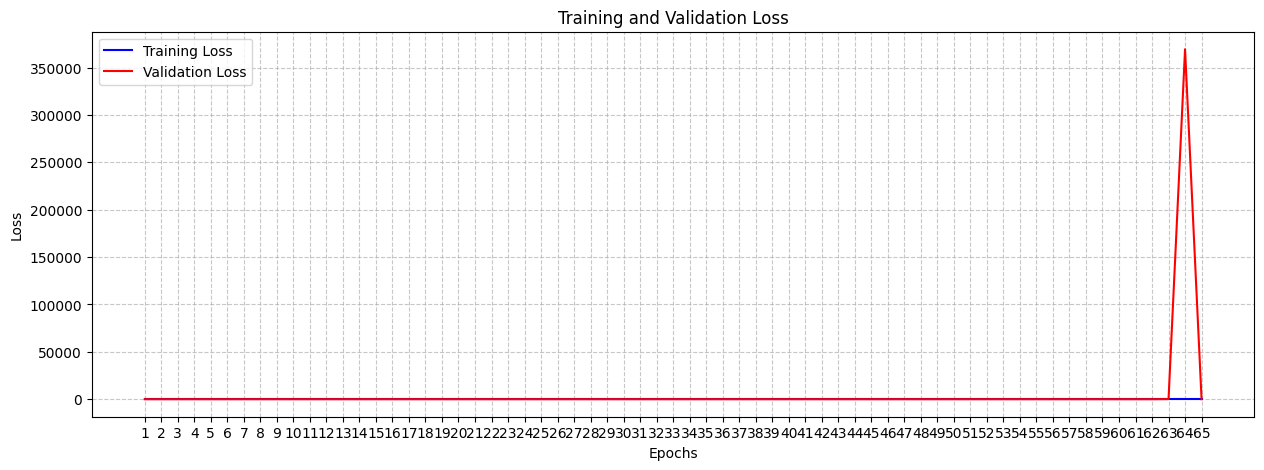

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
forecaster.plot_history(ax=ax)

In [13]:
predictions = forecaster.predict()
predictions

,NIVEL_RIO_Aitzu-Urola
2001-03-05 12:00:00,19362.847656


In [14]:
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster = forecaster,
    steps = forecaster.max_step,
    series = data_river ,
    levels = forecaster.levels,
    initial_train_size = len(data_train) + len(data_val),
    metric = "mean_absolute_error",
    verbose = False,
    refit = False
)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - loss: 2.6639e-04 - val_loss: 8.8719e-04
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 2.7314e-04 - val_loss: 7.8730e-04
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.5656e-04 - val_loss: 7.8055e-04
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.7104e-04 - val_loss: 0.0124
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.8571e-04 - val_loss: 0.0015
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.6572e-04 - val_loss: 0.0016
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2.5134e-04 - val_loss: 0.0123
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.5869e-04 - val_loss: 2.8210


100%|██████████| 3703/3703 [05:09<00:00, 11.96it/s]


In [15]:
predictions

,NIVEL_RIO_Aitzu-Urola
2001-08-06 17:00:00,0.092362
2001-08-06 18:00:00,0.090130
2001-08-06 19:00:00,0.100532
2001-08-06 20:00:00,0.107715
2001-08-06 21:00:00,0.117033
...,...
2002-01-07 19:00:00,0.169602
2002-01-07 20:00:00,0.165954
2002-01-07 21:00:00,0.164465
2002-01-07 22:00:00,0.163471


In [16]:
x = 0
num_values_to_pred = int(nan_sequences[x]['num_nans'])
end_train = nan_sequences[0]['end_date'] - pd.Timedelta('1 hour')
date_pred = nan_sequences[0]['end_date']
print(end_train)
print(date_pred)
data_river_pred = imputation_lluvia_aitsu[:end_train]

def predict_next_value (forecaster, last_data):
    last_data = last_data[forecaster.levels] 
    last_data = last_data[-120:].to_numpy()
    input_data = last_data.reshape(1, 120, len(forecaster.levels))
    prediction = forecaster.regressor.predict(input_data)
    return prediction

last_data = data_river_pred
next_prediction = predict_next_value(forecaster, last_data)
# d = {'date_pred': [date_pred], 'prediction': next_prediction[:,1:,1]} 
# df = pd.DataFrame(data=d)
print(next_prediction[:,-num_values_to_pred:])


2002-01-07 23:00:00
2002-01-08 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[[0.16162458]]]


In [16]:
imputation_lluvia_aitsu.update(last_value_predict)
predictions

,NIVEL_RIO_Aitzu-Urola
2001-08-06 17:00:00,0.096487
2001-08-06 18:00:00,0.093877
2001-08-06 19:00:00,0.100991
2001-08-06 20:00:00,0.102748
2001-08-06 21:00:00,0.104427
...,...
2002-01-07 19:00:00,0.187632
2002-01-07 20:00:00,0.184496
2002-01-07 21:00:00,0.186658
2002-01-07 22:00:00,0.182195


In [17]:
# start = nan_sequences[0]['end_date']
# end = nan_sequences[0]['end_date']
# # print(start)
# # print(end)
# data0 = data_river_2['NIVEL_RIO_Aitzu'].loc[start:end].copy()
# data0_predictions = forecaster.predict(None)

In [15]:
rel_mse = 100 * metrics.loc[0, "mean_absolute_error"] / np.mean(data)
print(f"Serie mean: {np.mean(data)}")
print(f"Relative error (mae): {rel_mse:.2f}%")

Serie mean: 0.22109402974587192
Relative error (mae): 7.12%


In [16]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_test.index, y=data_test.values.flatten(),
                         mode='lines', name='True', line=dict(color='blue', width=2)))

fig.add_trace(go.Scatter(x=predictions.index, y=predictions.values.flatten(),
                         mode='lines', name='Prediction', line=dict(color='green', width=2)))
fig.update_layout(
    title='Nivel del rio Aitzu-Urola', 
    xaxis_title='Fecha', 
    yaxis_title='Nivel del rio Aitzu-Urola',
    margin = dict(l=20, r=20, t=40, b=20),
    legend = dict(
        orientation = 'h',
        yanchor = 'top',
        y=1.02,
        xanchor = 'left',
        x=0
    ))

In [19]:
metrics

,levels,mean_absolute_error
0,NIVEL_RIO_Aitzu-Urola,0.023852


In [21]:
# print(forecaster.transformer_series.min_)
# print(forecaster.transformer_series.scale_)
# print(forecaster.transformer_series.n_samples_seen_)

In [22]:
# !pip install joblib
import joblib

# Directorio para guardar los archivos
save_dir = '/opt/dora/Dora/NAIR/IA4FLOOD/Urola/'
os.makedirs(save_dir, exist_ok=True)

# Guardar el modelo
def save_model_and_scaler(forecaster, save_dir):
    # Guardar el modelo
    model_path = os.path.join(save_dir, 'rnn_model.h5')
    save_model(forecaster.regressor, model_path)
    print(f"Modelo guardado en: {model_path}")

    # Guardar el scaler
    scaler_path = os.path.join(save_dir, 'scaler.pkl')
    joblib.dump(forecaster.transformer_series, scaler_path)
    print(f"Scaler guardado en: {scaler_path}")

    # Guardar otros parámetros importantes del forecaster si es necesario
    params_path = os.path.join(save_dir, 'forecaster_params.pkl')
    params = {
        'levels': forecaster.levels,
        'lags': forecaster.lags,
        'steps': forecaster.max_step
    }
    joblib.dump(params, params_path)
    print(f"Parámetros del forecaster guardados en: {params_path}")

def load_model_and_scaler(save_dir):
    # Cargar el modelo
    model_path = os.path.join(save_dir, 'rnn_model.h5')
    model = load_model(model_path)
    print(f"Modelo cargado desde: {model_path}")

    # Cargar el scaler
    scaler_path = os.path.join(save_dir, 'scaler.pkl')
    scaler = joblib.load(scaler_path)
    print(f"Scaler cargado desde: {scaler_path}")

    # Cargar otros parámetros
    params_path = os.path.join(save_dir, 'forecaster_params.pkl')
    params = joblib.load(params_path)

    # Recrear el forecaster
    forecaster = ForecasterRnn(
        regressor=model,
        levels=params['levels'],
        transformer_series=scaler,
    )
    forecaster.lags = params['lags']
    forecaster.max_step = params['steps']

    return forecaster

# save_model_and_scaler(forecaster, save_dir)

# Cargar
forecaster = load_model_and_scaler(save_dir)
print("Forecaster cargado y listo para hacer predicciones.")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/opt/dora/Dora/NAIR/IA4FLOOD/Urola/rnn_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [21]:
def get_latest_data(n_hours=60):
    """
    Función para obtener los datos más recientes.
    En un entorno de producción, esto podría ser una llamada a una API o base de datos.
    """
    # Aquí deberías implementar la lógica para obtener los datos más recientes
    # Por ahora, usaremos datos de ejemplo
    return pd.DataFrame(np.random.rand(n_hours, 1), 
                        columns=['NIVEL_RIO_Aitzu-Urola'],
                        index=pd.date_range(end=pd.Timestamp.now(), periods=n_hours, freq='H'))

datas = get_latest_data()

def predict_future_steps(forecaster, last_data, steps):
    predictions = []
    data_for_prediction = last_data.copy()

    for _ in range(steps):
        # Preparar los datos para la predicción
        input_data = data_for_prediction.values.reshape(1, -1, 1)
        
        # Hacer la predicción
        prediction = forecaster.predict(steps=1, levels=input_data)
        next_value = prediction.values[0][0]

        predictions.append(next_value)

        # Actualizar los datos para la siguiente predicción
        data_for_prediction = data_for_prediction.iloc[1:].append(
            pd.DataFrame([next_value], columns=forecaster.levels, index=[data_for_prediction.index[-1] + pd.Timedelta(hours=1)])
        )

    return predictions

# Función principal para hacer predicciones
def make_production_prediction(hours_to_predict=24):
    # Obtener los datos más recientes
    latest_data = get_latest_data()

    # Hacer predicciones
    predictions = predict_future_steps(forecaster, latest_data, hours_to_predict)

    # Crear un DataFrame con las predicciones
    prediction_dates = pd.date_range(start=latest_data.index[-1] + pd.Timedelta(hours=1), 
                                     periods=hours_to_predict, freq='H')
    predictions_df = pd.DataFrame(predictions, index=prediction_dates, columns=['NIVEL_RIO_Aitzu-Urola'])

    return predictions_df

# Ejemplo de uso
if __name__ == "__main__":
    predictions = make_production_prediction()
    print(predictions)